Loading and merging data...
Error loading depression_prevalence.csv: 'utf-8' codec can't decode byte 0xfc in position 28323: invalid start byte
Error loading suicide_rates.csv: 'utf-8' codec can't decode byte 0xfc in position 168394: invalid start byte
Error loading Obesity among adults, BMI = 30 prevalence (crude estimate).csv: 'utf-8' codec can't decode byte 0xfc in position 39758: invalid start byte
Error loading Obesity among adults,BMI = 30 prevalence_age-standardized estimate).csv: [Errno 2] No such file or directory: 'Obesity among adults,BMI = 30 prevalence_age-standardized estimate).csv'
Error loading Overweight among adults, BMI = 25 prevalence (crude estimate).csv: 'utf-8' codec can't decode byte 0xfc in position 109615: invalid start byte
Error loading Overweight among adults, BMI = 25 prevalence (age-standardized estimate).csv: 'utf-8' codec can't decode byte 0xfc in position 17523: invalid start byte
Error loading Underweight among adults, BMI  18.5 prevalence (crude esti

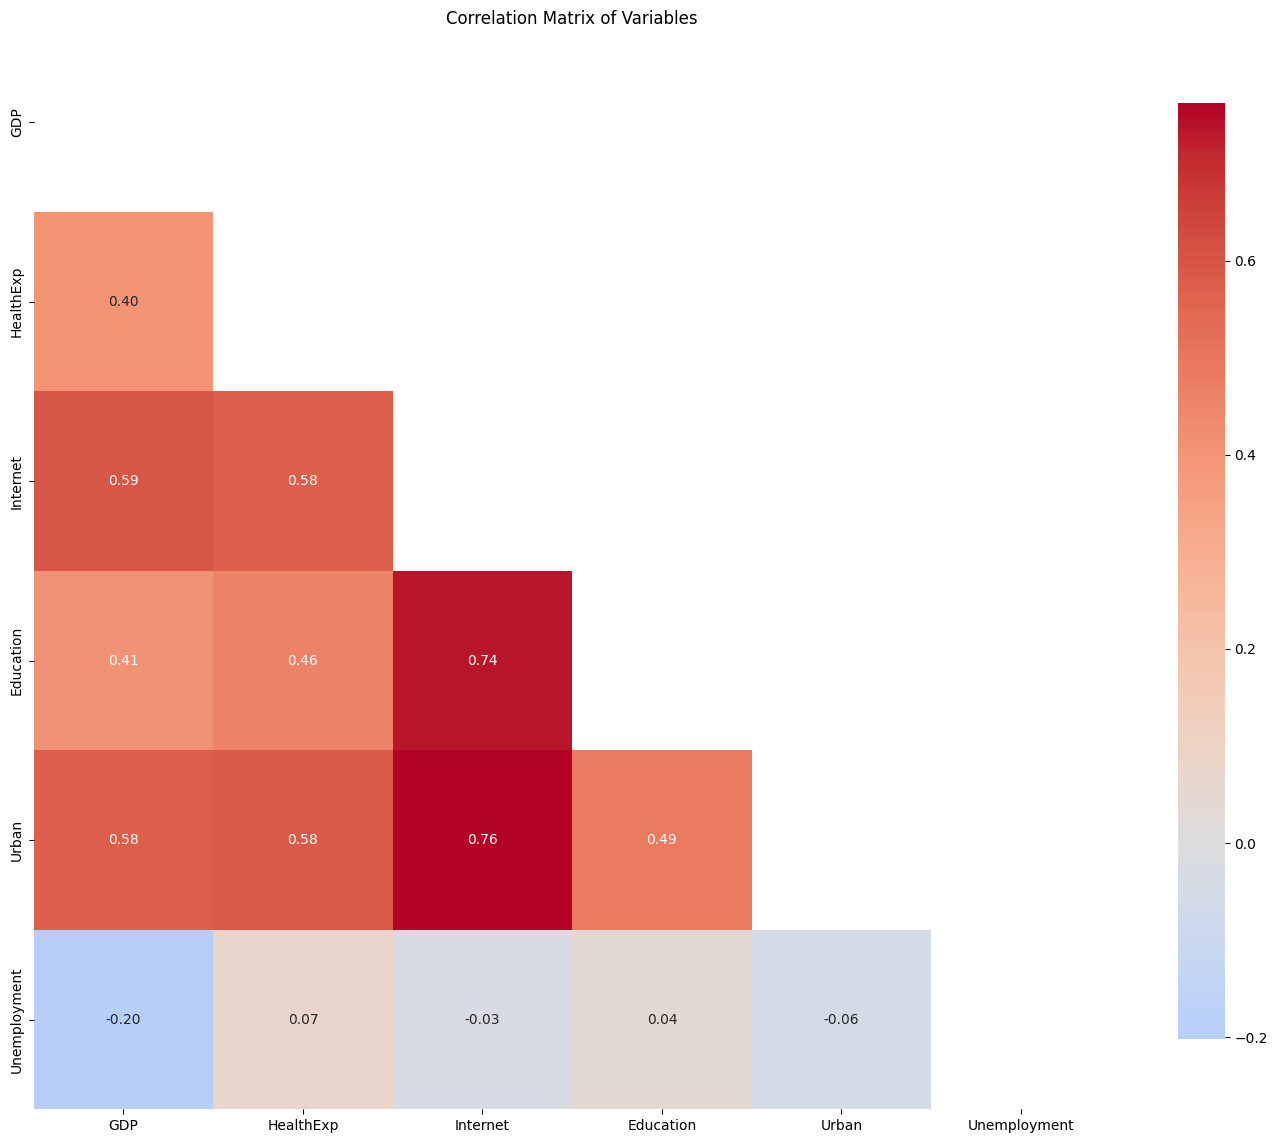


No highly correlated pairs found.

Scaling features using standard method...
Features scaled successfully.

Applying PCA for dimensionality reduction...
PCA completed. Explained variance ratio: [0.54346898 0.18238762 0.09919123 0.08625672 0.06323311]
Total variance explained: 0.975


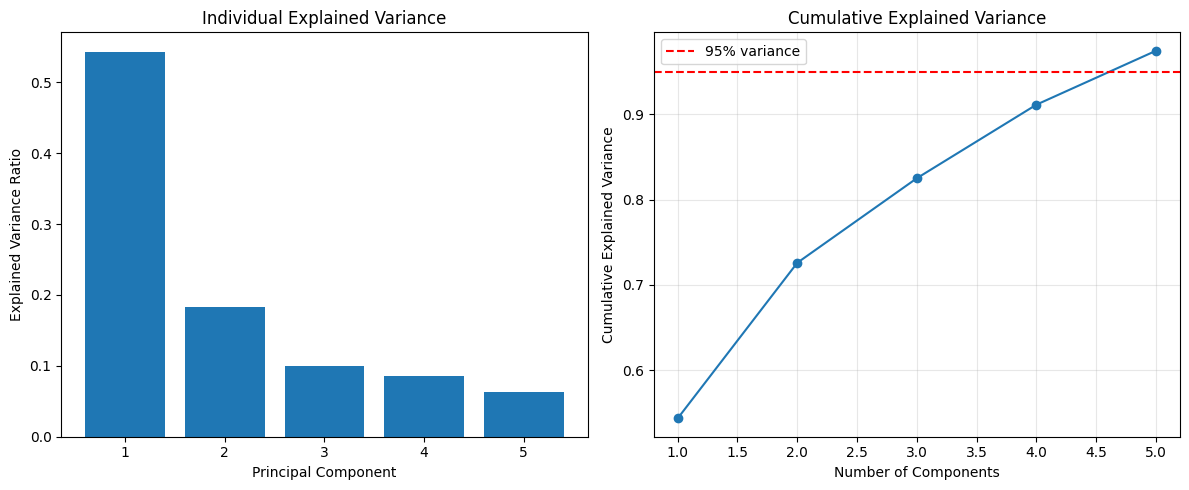


Preparing data for association rules with 3 bins...
Association rules data prepared for 111 countries.

Saving processed datasets...
Saved: processed_mental_health_data.csv
Saved: scaled_mental_health_data.csv
Saved: pca_mental_health_data.csv
Saved: association_rules_data.csv
All datasets saved successfully!

PREPROCESSING COMPLETE!
Generated files for further analysis:
- processed_mental_health_data.csv (main dataset)
- scaled_mental_health_data.csv (for clustering)
- pca_mental_health_data.csv (for dimensionality reduction)
- association_rules_data.csv (for association rule mining)

You can now proceed with:
1. Clustering analysis (K-means, hierarchical)
2. Association rule mining
3. Anomaly detection
4. Statistical modeling


In [ ]:
# ============================================================== #
# Data Mining Project: Mental Health, Social & Economic Factors  #
# ============================================================== #

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

class MentalHealthDataPreprocessor:
    def __init__(self, year="2021"):
        self.year = year
        self.master_df = None
        self.scaler = StandardScaler()
        
    def load_wb_csv(self, filename, value_col, year="2021", country_col="Country Name"):
        """
        Load World Bank CSVs (with metadata rows).
        Extracts Country and values for a given year.
        """
        try:
            df = pd.read_csv(filename, skiprows=4)
            if year not in df.columns:
                # fallback: take latest available year
                numeric_cols = [c for c in df.columns if c.isdigit()]
                year = numeric_cols[-1] if numeric_cols else "2021"
            df = df[[country_col, year]]
            df.columns = ["Country", value_col]
            df = df.dropna()
            return df
        except Exception as e:
            print(f"Error loading {filename}: {e}")
            return pd.DataFrame(columns=["Country", value_col])

    def load_who_csv(self, filename, value_col):
        """
        Load WHO CSVs (with Location, FactValueNumeric).
        Filters for 'Both sexes' and latest year if available.
        """
        try:
            df = pd.read_csv(filename, on_bad_lines='skip')
            if "Location" in df.columns and "FactValueNumeric" in df.columns:
                # optional filters
                if "Dim1" in df.columns:
                    df = df[df["Dim1"] == "Both sexes"]
                if "Period" in df.columns:
                    # Get the latest year for each country
                    latest_years = df.groupby("Location")["Period"].max().reset_index()
                    df = df.merge(latest_years, on=["Location", "Period"])
                df = df[["Location", "FactValueNumeric"]]
                df.columns = ["Country", value_col]
                df = df.dropna()
                return df
            else:
                print(f"{filename} does not match WHO format, skipping")
                return pd.DataFrame(columns=["Country", value_col])
        except Exception as e:
            print(f"Error loading {filename}: {e}")
            return pd.DataFrame(columns=["Country", value_col])
    
    def load_and_merge_data(self):
        """Load individual datasets and merge them using your CSV structure"""
        print("Loading and merging data...")
        
        try:
            # WHO datasets
            depression_df = self.load_who_csv("depression_prevalence.csv", "Depression")
            suicide_df = self.load_who_csv("suicide_rates.csv", "Suicide")

            # BMI & Nutrition WHO Datasets
            obesity_crude_df = self.load_who_csv(
                "Obesity among adults, BMI = 30 prevalence (crude estimate).csv", "ObesityCrude"
            )
            obesity_std_df = self.load_who_csv(
                "Obesity among adults,BMI = 30 prevalence_age-standardized estimate).csv", "ObesityStd"
            )
            overweight_crude_df = self.load_who_csv(
                "Overweight among adults, BMI = 25 prevalence (crude estimate).csv", "OverweightCrude"
            )
            overweight_std_df = self.load_who_csv(
                "Overweight among adults, BMI = 25 prevalence (age-standardized estimate).csv", "OverweightStd"
            )
            underweight_crude_df = self.load_who_csv(
                "Underweight among adults, BMI  18.5 prevalence (crude estimate).csv", "UnderweightCrude"
            )
            underweight_std_df = self.load_who_csv(
                "Underweight among adults, BMI  18.5 prevalence (age-standardized estimate).csv", "UnderweightStd"
            )

            # World Bank datasets 
            gdp_df = self.load_wb_csv("gdp_per_capita.csv", "GDP", year=self.year)
            health_exp_df = self.load_wb_csv("health_expenditure.csv", "HealthExp", year=self.year)
            internet_df = self.load_wb_csv("internet_usage.csv", "Internet", year=self.year)
            education_df = self.load_wb_csv("education_attainment.csv", "Education", year=self.year)
            urban_df = self.load_wb_csv("urban_population.csv", "Urban", year=self.year)
            unemployment_df = self.load_wb_csv("unemployment.csv", "Unemployment", year=self.year)

            # List all dataframes for merging
            all_dfs = [
                depression_df, suicide_df, obesity_crude_df, obesity_std_df,
                overweight_crude_df, overweight_std_df, underweight_crude_df, underweight_std_df,
                gdp_df, health_exp_df, internet_df, education_df, urban_df, unemployment_df
            ]
            
            # Filter out empty dataframes
            dfs_nonempty = [df for df in all_dfs if not df.empty and len(df) > 0]
            
            if len(dfs_nonempty) == 0:
                print("No non-empty datasets to merge.")
                return False
            
            # Merge all datasets
            self.master_df = dfs_nonempty[0]
            for i, df in enumerate(dfs_nonempty[1:]):
                self.master_df = self.master_df.merge(df, on="Country", how="inner")
                print(f"Merged {df.columns[1]} - Current shape: {self.master_df.shape}")
            
            print(f"Final merged dataset shape: {self.master_df.shape}")
            print(f"Columns: {self.master_df.columns.tolist()}")
            return True
            
        except Exception as e:
            print(f"Error in load_and_merge_data: {e}")
            return False
    
    def explore_data(self):
        """Perform initial data exploration"""
        if self.master_df is None or self.master_df.empty:
            print("No data to explore.")
            return
            
        print("\n=== DATA EXPLORATION ===")
        
        # Basic info
        print("Dataset Info:")
        print(self.master_df.info())
        
        # Missing values analysis
        print("\nMissing Values by Column:")
        missing_info = (self.master_df.isnull().sum() / len(self.master_df)) * 100
        missing_info = missing_info[missing_info > 0].sort_values(ascending=False)
        if len(missing_info) > 0:
            print(missing_info)
        else:
            print("No missing values!")
        
        # Basic statistics
        print("\nDescriptive Statistics:")
        print(self.master_df.describe())
        
        # Visualize missing data
        if len(missing_info) > 0:
            plt.figure(figsize=(12, 6))
            missing_info.plot(kind='bar')
            plt.title('Missing Values by Column')
            plt.ylabel('Percentage Missing')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        
    def handle_missing_values(self, method='knn', k=5):
        """Handle missing values using specified method"""
        if self.master_df is None or self.master_df.empty:
            print("No data to process.")
            return
            
        print(f"\nHandling missing values using {method} method...")
        
        # Check if there are any missing values
        if self.master_df.isnull().sum().sum() == 0:
            print("No missing values to handle.")
            return
        
        # Create a copy for imputation
        df_imputed = self.master_df.select_dtypes(include=[np.number]).copy()
        
        if method == 'median':
            # Simple median imputation
            for column in df_imputed.columns:
                if df_imputed[column].isnull().sum() > 0:
                    median_val = df_imputed[column].median()
                    df_imputed[column].fillna(median_val, inplace=True)
                    print(f"Imputed {column} with median: {median_val:.2f}")
                    
        elif method == 'knn':
            # KNN imputation
            imputer = KNNImputer(n_neighbors=k)
            imputed_array = imputer.fit_transform(df_imputed)
            df_imputed = pd.DataFrame(imputed_array, 
                                    columns=df_imputed.columns, 
                                    index=df_imputed.index)
            print(f"Used KNN imputation with k={k}")
        
        # Update the master dataframe with imputed numerical values
        for column in df_imputed.columns:
            self.master_df[column] = df_imputed[column]
            
        print(f"Missing values after imputation: {self.master_df.isnull().sum().sum()}")
    
    def check_correlations(self):
        """Check correlations between variables"""
        if self.master_df is None or self.master_df.empty:
            print("No data for correlation analysis.")
            return None
            
        print("\n=== CORRELATION ANALYSIS ===")
        
        # Calculate correlation matrix
        numeric_df = self.master_df.select_dtypes(include=[np.number])
        if numeric_df.empty:
            print("No numeric columns for correlation analysis.")
            return None
            
        corr_matrix = numeric_df.corr()
        
        # Plot correlation heatmap
        plt.figure(figsize=(14, 12))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', 
                   center=0, square=True, fmt='.2f', cbar_kws={"shrink": .8})
        plt.title('Correlation Matrix of Variables')
        plt.tight_layout()
        plt.show()
        
        # Identify highly correlated pairs (absolute correlation > 0.8)
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                if abs(corr_matrix.iloc[i, j]) > 0.8:
                    high_corr_pairs.append((
                        corr_matrix.columns[i],
                        corr_matrix.columns[j],
                        corr_matrix.iloc[i, j]
                    ))
        
        if high_corr_pairs:
            print("\nHighly correlated pairs (|r| > 0.8):")
            for pair in high_corr_pairs:
                print(f"  {pair[0]} - {pair[1]}: {pair[2]:.3f}")
        else:
            print("\nNo highly correlated pairs found.")
            
        # Focus on correlations with Depression and Suicide
        if 'Depression' in corr_matrix.columns:
            print("\nTop correlations with Depression:")
            depression_corr = corr_matrix['Depression'].sort_values(ascending=False)
            print(depression_corr.head(10))
            
        if 'Suicide' in corr_matrix.columns:
            print("\nTop correlations with Suicide:")
            suicide_corr = corr_matrix['Suicide'].sort_values(ascending=False)
            print(suicide_corr.head(10))
            
        return high_corr_pairs
    
    def scale_features(self, method='standard'):
        """Scale features for clustering"""
        if self.master_df is None or self.master_df.empty:
            print("No data to scale.")
            return None
            
        print(f"\nScaling features using {method} method...")
        
        # Select numerical columns to scale
        numerical_cols = self.master_df.select_dtypes(include=[np.number]).columns.tolist()
        
        if not numerical_cols:
            print("No numeric columns to scale.")
            return None
        
        # Remove target variables from scaling if they exist
        targets = ['Depression', 'Suicide']
        features_to_scale = [col for col in numerical_cols if col not in targets]
        
        if method == 'standard':
            scaler = StandardScaler()
        elif method == 'minmax':
            scaler = MinMaxScaler()
        else:
            print("Unknown scaling method. Using StandardScaler.")
            scaler = StandardScaler()
        
        # Scale the features
        scaled_features = scaler.fit_transform(self.master_df[features_to_scale])
        
        # Create a new dataframe with scaled features
        self.master_df_scaled = self.master_df.copy()
        self.master_df_scaled[features_to_scale] = scaled_features
        
        print("Features scaled successfully.")
        return scaler
    
    def reduce_dimensionality(self, n_components=None):
        """Apply PCA for dimensionality reduction"""
        if not hasattr(self, 'master_df_scaled') or self.master_df_scaled is None:
            print("Please scale features first.")
            return None
            
        print("\nApplying PCA for dimensionality reduction...")
        
        # Get scaled features (excluding targets and non-numeric)
        scaled_cols = self.master_df_scaled.select_dtypes(include=[np.number]).columns.tolist()
        targets = ['Depression', 'Suicide']
        features_for_pca = [col for col in scaled_cols if col not in targets]
        
        X_scaled = self.master_df_scaled[features_for_pca]
        
        # Determine optimal number of components if not specified
        if n_components is None:
            pca_test = PCA()
            pca_test.fit(X_scaled)
            explained_variance = np.cumsum(pca_test.explained_variance_ratio_)
            n_components = np.argmax(explained_variance >= 0.95) + 1
            if n_components == 0:  # If 95% not reached with first component
                n_components = 1
            print(f"Selected {n_components} components explaining {explained_variance[n_components-1]:.1%} of variance")
        
        # Apply PCA
        pca = PCA(n_components=n_components)
        principal_components = pca.fit_transform(X_scaled)
        
        # Create PCA dataframe
        pca_columns = [f'PC{i+1}' for i in range(n_components)]
        self.pca_df = pd.DataFrame(principal_components, columns=pca_columns, index=self.master_df_scaled.index)
        
        # Add country names back
        self.pca_df['Country'] = self.master_df_scaled['Country']
        
        print(f"PCA completed. Explained variance ratio: {pca.explained_variance_ratio_}")
        print(f"Total variance explained: {np.sum(pca.explained_variance_ratio_):.3f}")
        
        # Plot explained variance
        self.plot_explained_variance(pca)
        
        return pca
    
    def plot_explained_variance(self, pca):
        """Plot PCA explained variance"""
        plt.figure(figsize=(12, 5))
        
        # Individual explained variance
        plt.subplot(1, 2, 1)
        components = range(1, len(pca.explained_variance_ratio_) + 1)
        plt.bar(components, pca.explained_variance_ratio_)
        plt.xlabel('Principal Component')
        plt.ylabel('Explained Variance Ratio')
        plt.title('Individual Explained Variance')
        
        # Cumulative explained variance
        plt.subplot(1, 2, 2)
        plt.plot(components, np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('Cumulative Explained Variance')
        plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def prepare_association_rules_data(self, n_bins=3):
        """Discretize data for association rule mining"""
        if self.master_df is None or self.master_df.empty:
            print("No data for association rules.")
            return None
            
        print(f"\nPreparing data for association rules with {n_bins} bins...")
        
        # Select relevant columns (adjust based on your actual columns)
        potential_columns = ['GDP', 'HealthExp', 'Unemployment', 'Internet', 
                           'Education', 'Urban', 'Depression', 'Suicide',
                           'ObesityCrude', 'ObesityStd', 'OverweightCrude', 
                           'OverweightStd', 'UnderweightCrude', 'UnderweightStd']
        
        # Filter to existing columns
        ar_columns = [col for col in potential_columns if col in self.master_df.columns]
        
        if not ar_columns:
            print("No suitable columns for association rules.")
            return None
            
        ar_data = self.master_df[['Country'] + ar_columns].copy()
        
        # Discretize each column into bins
        for column in ar_columns:
            try:
                if column in ['Depression', 'Suicide']:
                    # For target variables, use descriptive labels
                    bins = pd.qcut(ar_data[column], n_bins, labels=[f'Low_{column}', f'Medium_{column}', f'High_{column}'][:n_bins], duplicates='drop')
                else:
                    bins = pd.qcut(ar_data[column], n_bins, labels=[f'Low_{column}', f'Medium_{column}', f'High_{column}'][:n_bins], duplicates='drop')
                
                ar_data[f'{column}_level'] = bins
            except Exception as e:
                print(f"Could not discretize {column}: {e}")
                # Remove column if discretization fails
                ar_columns.remove(column)
        
        # Create transaction format for association rules
        transaction_data = []
        country_list = []
        for _, row in ar_data.iterrows():
            transaction = []
            for col in ar_columns:
                level_col = f'{col}_level'
                if level_col in row and pd.notna(row[level_col]):
                    transaction.append(row[level_col])
            if transaction:  # Only add if we have some data
                transaction_data.append(transaction)
                country_list.append(row['Country'])
        
        self.transaction_df = pd.DataFrame({
            'Country': country_list,
            'Transaction': transaction_data
        })
        
        print(f"Association rules data prepared for {len(transaction_data)} countries.")
        return self.transaction_df
    
    def save_processed_data(self):
        """Save processed datasets for different analyses"""
        if self.master_df is None or self.master_df.empty:
            print("No data to save.")
            return
            
        print("\nSaving processed datasets...")
        
        # Save main dataset
        self.master_df.to_csv('processed_mental_health_data.csv', index=False)
        print("Saved: processed_mental_health_data.csv")
        
        # Save scaled dataset for clustering
        if hasattr(self, 'master_df_scaled') and self.master_df_scaled is not None:
            self.master_df_scaled.to_csv('scaled_mental_health_data.csv', index=False)
            print("Saved: scaled_mental_health_data.csv")
        
        # Save PCA dataset
        if hasattr(self, 'pca_df') and self.pca_df is not None:
            self.pca_df.to_csv('pca_mental_health_data.csv', index=False)
            print("Saved: pca_mental_health_data.csv")
        
        # Save association rules data
        if hasattr(self, 'transaction_df') and self.transaction_df is not None:
            self.transaction_df.to_csv('association_rules_data.csv', index=False)
            print("Saved: association_rules_data.csv")
        
        print("All datasets saved successfully!")

# Main execution
def main():
    # Initialize preprocessor
    preprocessor = MentalHealthDataPreprocessor(year="2021")
    
    # Step 1: Load and merge data
    if not preprocessor.load_and_merge_data():
        print("Failed to load data. Please check file paths.")
        return
    
    # Step 2: Explore initial data
    preprocessor.explore_data()
    
    # Step 3: Handle missing values
    preprocessor.handle_missing_values(method='knn', k=5)
    
    # Step 4: Check correlations
    high_corr_pairs = preprocessor.check_correlations()
    
    # Step 5: Scale features for clustering
    preprocessor.scale_features(method='standard')
    
    # Step 6: Dimensionality reduction
    preprocessor.reduce_dimensionality(n_components=5)
    
    # Step 7: Prepare data for association rules
    preprocessor.prepare_association_rules_data(n_bins=3)
    
    # Step 8: Save all processed datasets
    preprocessor.save_processed_data()
    
    print("\n" + "="*50)
    print("PREPROCESSING COMPLETE!")
    print("="*50)
    print("Generated files for further analysis:")
    print("- processed_mental_health_data.csv (main dataset)")
    print("- scaled_mental_health_data.csv (for clustering)")
    print("- pca_mental_health_data.csv (for dimensionality reduction)")
    print("- association_rules_data.csv (for association rule mining)")
    print("\nYou can now proceed with:")
    print("1. Clustering analysis (K-means, hierarchical)")
    print("2. Association rule mining")
    print("3. Anomaly detection")
    print("4. Statistical modeling")

if __name__ == "__main__":
    main()